101
101


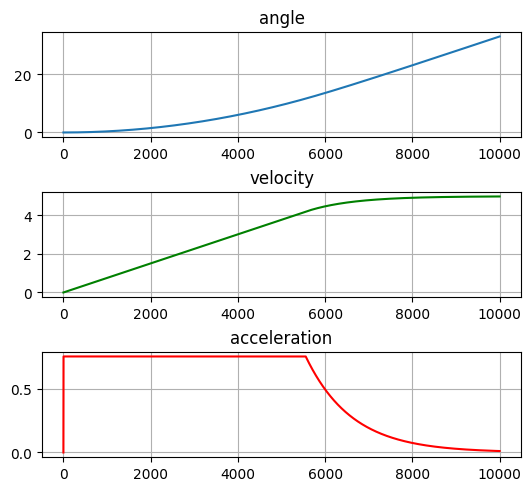

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from matplotlib import pyplot as plt
from math import pi


class VehicleSimpleDynamic:
    def __init__(self, k_b, l, Iy, accInit, velInit, angleInit):
        '''
        :param k_b: коэффициент тяги двигателя
        :param l: длина базы
        :param Iy: момент инерции
       '''
        self.k_b = k_b
        self.l = l
        self.Iy = Iy
        self.angle_acceleration = accInit
        self.angle_velocity = velInit
        self.angle = angleInit

    # rotorsAngularVel: float угловая скорость двигателей
    def rightParts(self, Acmd):

        # угловые скорости вращения винтов
        omega1 = Acmd + Tcmd
        omega2 = -Acmd + Tcmd

        My = self.k_b * self.l * (omega1**2 - omega2**2)

        self.angle_acceleration = My / Iy

    def integrate(self, dt):  # dt: шаг моделирования
        # интегрируем ускорение методом эйлера
        self.angle_velocity += self.angle_acceleration * dt
        # Полученную скорость интегрируем для определения местоположения
        self.angle += self.angle_velocity * dt

    def calculateParams(self, Acmd, dt):

        # Для определения положения вызываем метод для правых частей(то есть наших приращений от перемещения)
        # В данном случае приращением выступает ускорение нашей системы.
        # Для следования заданному целевому значению высоты передаем в метод наше управляющие воздействие u,
        # которое характеризует необходимую угловую скорость двигателей.
        self.rightParts(Acmd)
        # Далее вызываем метод интегрирования
        # Интегрируем полученное при помощи функции правых частей ускорение и получаем скорость,
        # после интегрируем скорость и получаем положение.
        self.integrate(dt)

    def getAngle(self):
        return self.angle  # положение ЛА

    def getAngleVelocity(self):
        return self.angle_velocity  # скорость ЛА

    def getAngleAcceleration(self):
        return self.angle_acceleration  # ускорение


class ControlSystem():
    def __init__(self, k_p, k_i, k_d, k_p_v, k_i_v, k_d_v, velocityControlLimit, accelerationControlLimit):
        self.k_p = k_p
        self.k_i = k_i
        self.k_d = k_d

        self.k_p_v = k_p_v
        self.k_i_v = k_i_v
        self.k_d_v = k_d_v

        self.error = 0
        self.pastError = 0

        self.desiredAngle = 0
        self.desiredVelocity = 0

        self.velocityError = 0
        self.velocityPastError = 0
        self.integral = 0
        self.velocityIntegral = 0
        self.velocityСontrolLimit = velocityControlLimit
        self.accelerationСontrolLimit = accelerationControlLimit

    def setDesiredAngle(self, desiredAngle): # устанавливка целевого угла тангажа ЛА, к которому система с течением времени будет стремиться
        self.desiredAngle = desiredAngle

    def setDesiredVelocity(self, desiredVelocity):
        # устанавливка целевой скорости по углу тангажа, к которому система с течением времени будет стремиться
        self.desiredVelocity = desiredVelocity

    def test_angle_PID(self, currentAngle, dt):
        '''
        :param currentAngle: текущее угол тангажа ЛА
        :param dt: шаг моделирования
        '''
        # Вычислим функцию ошибки
        self.error = self.desiredAngle - currentAngle
        # Вычисляем интеграл ошибки
        self.integral += self.error * dt
        # Получим рассчетную управляющую угловую скорость двигателей при помощи ПИД регулятора
        u = self.k_p * self.error + self.k_i * self.integral + \
            self.k_d * ((self.error - self.pastError) / dt)
        # Установим предыдущую ошибку для использования в дальнейших итерациях
        self.pastError = self.error
        # Вызовем звено насыщения для ограничения максимального управляющего воздействия
        u = self.saturation(u, self.velocityСontrolLimit)
        self.setDesiredVelocity(u)

        return u  # целевая угловая скроксть

    def velocity_PID(self, currentVelocity, dt):
        self.velocityError = self.desiredVelocity - currentVelocity

        self.velocityIntegral += self.error * dt

        Acmd = self.k_p_v * self.velocityError + self.k_i_v * self.velocityIntegral + \
            self.k_d_v * ((self.velocityError - self.velocityPastError) / dt)
        # Установим предыдущую ошибку для использования в дальнейших итерациях
        self.velocityPastError = self.velocityError
        # Вызовем звено насыщения для ограничения максимального управляющего воздействия
        Acmd = self.saturation(Acmd, self.accelerationСontrolLimit)

        return Acmd

    def saturation(self, inputVal, controlLimit):
        '''
        :param inputVal: входное значение
        :type inputVal: float
        :return: выходное значение после прохождения проверки на ограничение
        :rtype: float
        '''
        # Звено насыщения ограничивает размер входного параметра
        # На выходе метода,абсолютное значение не может быть больше
        # заданного предела controlLimit
        if inputVal > controlLimit:
            inputVal = controlLimit
        elif inputVal < -controlLimit:
            inputVal = - controlLimit

        return inputVal


class Simulator():

    def __init__(self, Tend, dt, controlSys, dynamicModel):
        '''
        :param Tend: конечное время моделирования
        :type Tend: float
        :param dt: шаг моделирования
        :type dt: float
        :param controlSys: объект системы управления высотой ЛА
        :type controlSys: ControlSystem
        :param dynamicModel: объект модели ЛА
        :type dynamicModel: VehicleSimpleDynamic
        '''
        self.dt = dt
        self.Tend = Tend
        self.controlSys = controlSys
        self.dynamicModel = dynamicModel
        self.angleAccList = []
        self.angleVelList = []
        self.angleList = []
        self.timeList = []

    def runSimulation(self):  # моделирование системы от 0 до конечного времени Tend с шагом dt
        # Задаем 0 время и начинаем рассчет до тех пор пока время не достигнет конечного значения Tend
        time = 0
        while (time <= self.Tend):
            # получаем угол тангаж ЛА
            angle = self.dynamicModel.getAngle()
            # Получаем угловую скорость ЛА
            velocity = self.dynamicModel.getAngleVelocity()
            # Получаем угловое ускорение ЛА
            acc = self.dynamicModel.getAngleAcceleration()
            # Записываем полученные значения в списки для построения графиков
            self.angleList.append(angle)
            self.angleVelList.append(velocity)
            self.angleAccList.append(acc)
            # self.timeList.append(time)

            # рассчитываем новое управляющие воздействие на основе текущего угла ЛА
            # u = self.controlSys.angle_PID(angle, self.dt)
            Acmd = self.controlSys.velocity_PID(velocity, self.dt)

            self.dynamicModel.calculateParams(Acmd, self.dt)
            # увеличиваем время на dt, то есть на шаг моделирования
            time += self.dt

    def showPlots(self):
        print(len(self.angleList[599:700]))
        print(len(self.angleAccList[599:700]))
        f = plt.figure(constrained_layout=True)
        gs = f.add_gridspec(3, 5)
        ax1 = f.add_subplot(gs[0, :-1])
        ax1.plot(self.angleList)
        ax1.grid()
        ax1.set_title('angle')

        ax2 = f.add_subplot(gs[1, :-1])
        ax2.plot(self.angleVelList, "g")
        ax2.grid()
        ax2.set_title('velocity')

        ax3 = f.add_subplot(gs[2, :-1])
        ax3.plot(self.angleAccList, "r")
        ax3.grid()
        ax3.set_title('acceleration')

        plt.show()


'''
 Объявим параметры для моделирования
'''
k_p = 50  # коэффициент Пропорционального регулирования
k_i = 0  # коэффициент Интегрального регулирования
k_d = 0  # коэффициент Дифференциального регулирования

k_p_v = 250  # коэффициент Пропорционального регулирования для контура по скорости
k_i_v = 0  # коэффициент Интегрального регулирования для контура по скорости
k_d_v = 0  # коэффициент Дифференциального регулирования для контура по скорости

dt = 0.001  # шаг моделирования системы, сек
Tend = 10  # конечное время моделирования, сек
Tcmd = 10  # требуемая тяга

# Коэффициент тяги двигателя ЛА
k_b = 3.9865e-08
# момент инерции
Iy = 7.16914e-05
# длина базы
l = 0.17
# Ограничение на угловую скорость поворота по углу тангажа, рад/сек
velocityControlLimit = 1000
accelerationControlLimit = 200

'''
Создадим объект контроллера и объект для нашей математической модели
'''
controller = ControlSystem(
    k_p, k_i, k_d, k_p_v, k_i_v, k_d_v,  velocityControlLimit, accelerationControlLimit)

uavSimpleDynamic = VehicleSimpleDynamic(k_b, l, Iy, 0, 0, 0)
'''
Установим целевой угол тангажа для нашей системы
'''
# desiredAngle = pi/6  # 30 degrees
desiredVelocity = 5
# controller.setDesiredAngle(desiredAngle)
controller.setDesiredVelocity(desiredVelocity)

"""
Создадим объект симулятора и передадим в него контроллер и математическую модель
"""
sim = Simulator(Tend, dt, controller, uavSimpleDynamic)
sim.runSimulation()  # запуск симулятора
sim.showPlots()  # построение графиков
